In [1]:

import pylabnet.hardware.awg.zi_hdawg as zi_hdawg
from pylabnet.utils.logging.logger import LogClient


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, display

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pylabnet.network.client_server import agilent_e4405B
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa_hardware

#!pip install seaborn
import itertools as it
import pandas as pd
import seaborn as sns

from pylabnet.utils.logging.logger import LogService
from pylabnet.network.core.generic_server import GenericServer
import os
import sys
from pylabnet.utils.iq_upconversion.optimizer import IQOptimizer, IQOptimizer_GD, IQOptimizer_GD_multifreq
#from pylabnet.utils.iq_upconversion.optimizer_temp import IQOptimizer as IQ_w_ports
#from pylabnet.utils.iq_upconversion.optimizer_temp import IQOptimizer_GD
from pylabnet.network.client_server import HMC_T2220

from pylabnet.network.client_server.agilent_83732b import Client

# Instantiante HDAWG

In [2]:
dev_id = 'dev8354'
# Instantiate Hardware class
hd = zi_hdawg.Driver(dev_id, None)

# Select channel grouping
#hd.set_channel_grouping(0)

#hd.enable_output(2)
#hd.enable_output(3)

In [4]:

awgModule = hd.daq.awgModule()
awgModule.set("device", hd.device_id)
awgModule.execute()

In [17]:
import textwrap
awg_program = textwrap.dedent(
        """\
        // Define placeholder with 1024 samples:
        wave p = ones(1024);

        while(true) {
            playWave(p);
            waitWave();
        }
        """
)

In [38]:
#awgModule.set("compiler/sourcefile", "RABI_indep.seqc")
#awgModule.set("compiler/sourcefile", awg_program)
#awgModule.set("compiler/start", 1)
awgModule.set("compiler/sourcestring", aa+bb)
    # Note: when using an AWG program from a source file (and only then), the compiler needs to
    # be started explicitly with awgModule.set('compiler/start', 1)
while awgModule.getInt("compiler/status") == -1:
    time.sleep(0.1)

In [32]:
plugin = f"""
        const DIO8 = 0b00000000000000000000000100000000;
        const DIO9and10 = 0b00000000000000000000011000000000;
        const DIO10 = 0b00000000000000000000010000000000;
        const DIO11 = 0b00000000000000000000100000000000;
        const OFF = 0b000000000000000000000000000000000;

        var start_freq = {0};
        var stop_freq = {110};
        var freq_step = {5}; 


        const t_green = 250000;
        const t_TiSa = 250000;
        var pi1_pulse_dur = {110};
        var pi2_pulse_dur = {110};
        var RF_pulse_dur = {110}; 

        const repeat_per_freq = {10};

        var trsh = {5}

"""

constant = """

        const ionized_trsh = 100; // after how many repeats do we send the green laser?

        wave pi1_pulse = ones(pi1_pulse_dur);
        wave pi1_zero = zeros(pi1_pulse_dur);
        wave pi2_pulse = ones(pi2_pulse_dur);
        wave pi2_zero = zeros(pi2_pulse_dur);

        var el_perro_verde = 0;

        for (var i = start_freq; i <= stop_freq; i = i + freq_step) {
        
            repeat (repeat_per_freq){
        
                setTrigger(0b0001);
                setDIO(DIO10);
                wait(t_TiSa);
                setDIO(OFF);
                setTrigger(0b0000);
                wait(t_TiSa);
            
                while (getCnt(0) > trsh) {
            
                    if (el_perro_verde > ionized_trsh) {
                        setDIO(DIO11);
                        wait(t_green);
                        setDIO(OFF);
                        wait(t_green);
                        
                        el_perro_verde = 0;
                    }
                    setInt('sines/0/oscselect', 0);
                    setInt('sines/2/oscselect', 0);
                    setInt('sines/0/harmonic', 1);
                    setInt('sines/2/harmonic', 1);
                    
                    setDIO(DIO8);
                    playWave(1, pi1_pulse, 1, pi1_zero, 3, pi1_pulse, 3, pi1_zero); //1st pi pulse
                    waitWave();
                    setDIO(OFF);
                    
                    wait(t_TiSa);
                    
                    setDIO(DIO8);
                    playWave(1, pi2_zero, 1, pi2_pulse, 3, pi2_zero, 3, pi2_pulse); //2nd pi pulse
                    waitWave();
                    setDIO(OFF);
                    
                    wait(t_TiSa);
                    
                    setTrigger(0b0001);
                    setDIO(DIO10);
                    wait(t_TiSa);
                    setDIO(OFF);
                    setTrigger(0b0000);
                    wait(t_TiSa);
                    
                    el_perro_verde += 1;
        
                }
            
                el_perro_verde = 0;
                
                setInt('sines/0/harmonic', i);
                setInt('sines/2/harmonic', i);
                setInt('sines/0/oscselect', 2);
                setInt('sines/2/oscselect', 2);
                
                setDIO(DIO8);
                playWave(1, pi1_pulse, 1, pi1_zero, 3, pi1_pulse, 3, pi1_zero); //1st pi pulse
                waitWave();
                setDIO(OFF);
                wait(t_TiSa);
                
                setDIO(DIO9and10);
                wait(t_TiSa);
                setDIO(OFF);
                wait(t_TiSa);
            
            }
        
        }


"""

In [35]:
plugin + constant

"\nconst DIO8 = 0b00000000000000000000000100000000;\nconst DIO9and10 = 0b00000000000000000000011000000000;\nconst DIO10 = 0b00000000000000000000010000000000;\nconst DIO11 = 0b00000000000000000000100000000000;\nconst OFF = 0b000000000000000000000000000000000;\n\nvar start_freq = 0;\nvar stop_freq = 110;\nvar freq_step = 5; \n\n\nconst t_green = 250000;\nconst t_TiSa = 250000;\nvar pi1_pulse_dur = 110;\nvar pi2_pulse_dur = 110;\nvar RF_pulse_dur = 110; \n\nconst repeat_per_freq = 10;\n\nvar trsh = 5\n\n\n\nconst ionized_trsh = 100; // after how many repeats do we send the green laser?\n\nwave pi1_pulse = ones(pi1_pulse_dur);\nwave pi1_zero = zeros(pi1_pulse_dur);\nwave pi2_pulse = ones(pi2_pulse_dur);\nwave pi2_zero = zeros(pi2_pulse_dur);\n\nvar el_perro_verde = 0;\n\nfor (var i = start_freq; i <= stop_freq; i = i + freq_step) {\n  \n  repeat (repeat_per_freq){\n  \n    setTrigger(0b0001);\n    setDIO(DIO10);\n    wait(t_TiSa);\n    setDIO(OFF);\n    setTrigger(0b0000);\n    wait(t_TiSa

In [39]:
aa

'\n        wave p = ones(30);\n        wave c = ones(30);\n \n        while(true) {\n            playWave(p);\n            waitWave();\n        }\n'

In [21]:
awg_program = textwrap.dedent(
        """\
        // Define placeholder with 1024 samples:
        wave p = ones({});

        while(true) {
            playWave(p);
            waitWave();
        }
        """.format(30)
)

KeyError: '\n            playWave(p);\n            waitWave();\n        '

In [27]:
aa = f"""
        wave p = ones({30});
        wave c = ones({30});
 """


In [28]:
bb= """
        while(true) {
            playWave(p);
            waitWave();
        }
"""

In [29]:
aa + bb

'\n        wave p = ones(30);\n        wave c = ones(30);\n \n        while(true) {\n            playWave(p);\n            waitWave();\n        }\n'

# Connect to MW client

In [ ]:
# Connect to MW source client
#mw_client = HMC_T2220.Client(
#    host='140.247.189.82',
#    port=2552
#)

# Connect to MW source client
mw = Client(
    host='140.247.189.178', 
    port=18460
)

In [4]:
# Check that MW source is set to correct power
# mw_client.output_on()
pow = 14  # -20 dBm
mw.set_power(pow)
mw.output_on()
#mw_client.get_power()

# Connect to Spectrum Analyzer

In [5]:
sa = agilent_e4405B.Client(
    host='192.168.50.108',
    port=6137
)

# Reset spectrum analzyer
sa.write('*RST')

(6, <StatusCode.success: 0>)

# Optimize

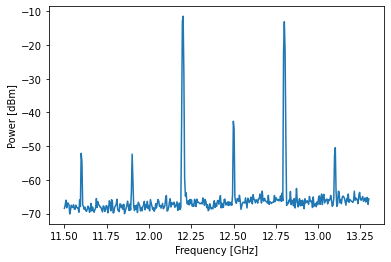

In [7]:
opt1 = IQOptimizer_GD(mw, hd, sa, 12.5e9, 300e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,3], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

In [14]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

KeyboardInterrupt: 

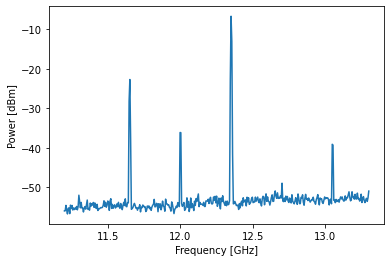

In [17]:
opt1 = IQOptimizer_GD(mw, hd, sa, 12e9, 350e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,3], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

In [16]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

KeyboardInterrupt: 

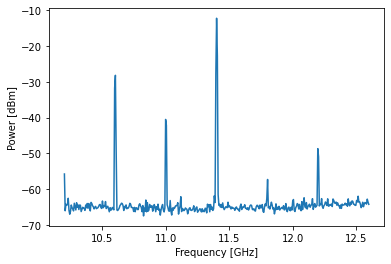

In [10]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11e9, 400e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

91.08602166175842


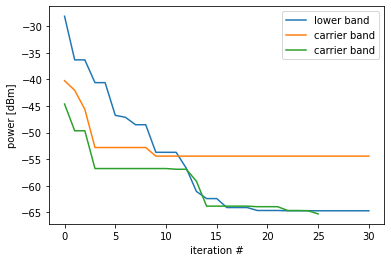

In [11]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

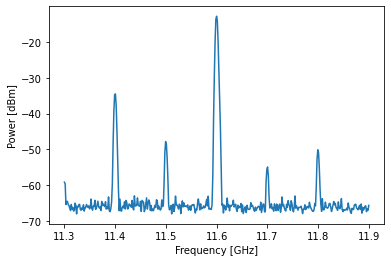

In [12]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11.5e9, 100e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

47.26195526123047


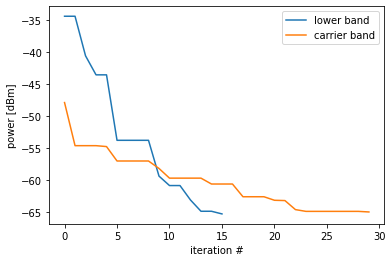

In [13]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

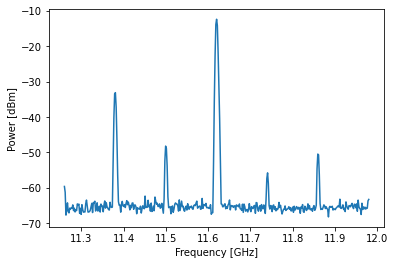

In [14]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11.5e9, 120e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

51.85113501548767


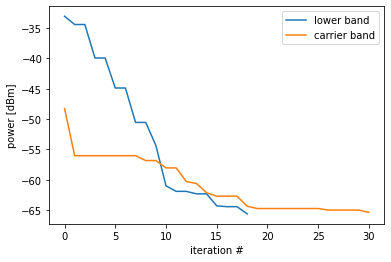

In [15]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

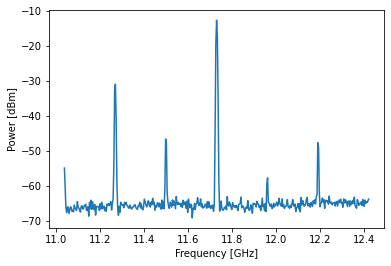

In [16]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11.5e9, 230e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

118.22234535217285


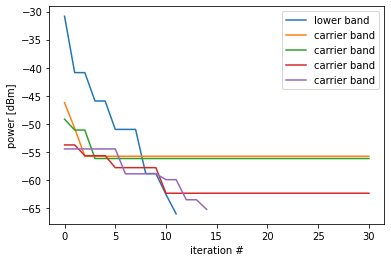

In [17]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

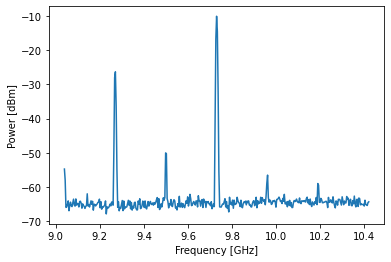

In [18]:
opt1 = IQOptimizer_GD(mw, hd, sa, 9.5e9, 230e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

48.07945227622986


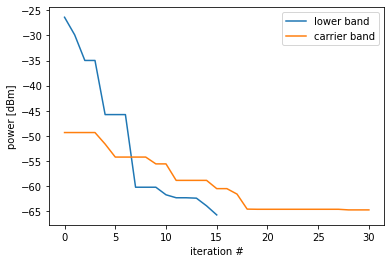

In [19]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

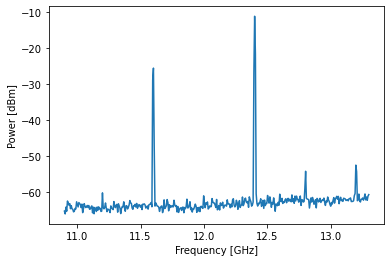

In [9]:
sa.plot_trace()

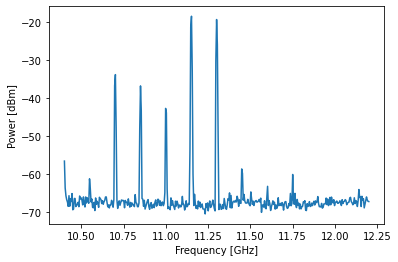

In [37]:
opt1 = IQOptimizer_GD_multifreq(mw, hd, sa, 11e9, [150e6, 300e6], param_guess = ([90, 90, 1, 1, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=[1,2], min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

58.780874729156494


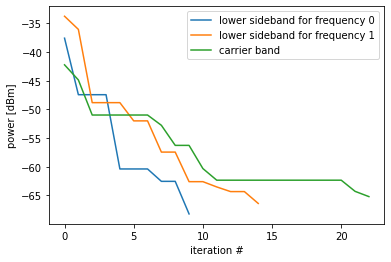

In [38]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)


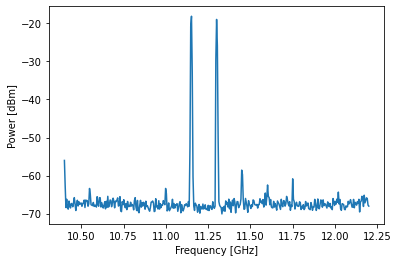

In [39]:
sa.plot_trace()